Import and load dataset

In [1]:
import pandas as pd

df = pd.read_csv("prepared_data/final_dataset.csv")

In [2]:
df.head()

,city_latitude,city_longitude,day_tempmax,day_tempmin,day_temp,day_precipcover,day_moonphase,hour_datetimeEpoch,hour_temp,hour_humidity,...,rifle,significant,southeast,southwest,state,unit,unspecified,wagner,within,would
0,50.7469,25.3263,4.9,0.7,2.6,4.17,0.77,1645653600,2.4,89.18,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,49.2336,28.4486,5.0,0.7,2.8,4.17,0.77,1645653600,2.1,91.76,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,48.5085,32.2656,6.2,-1.3,2.2,0.00,0.77,1645653600,0.0,82.64,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,49.4168,26.9743,4.7,0.2,2.3,8.33,0.77,1645653600,2.2,88.52,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,47.8289,35.1626,8.0,-2.0,3.3,0.00,0.77,1645653600,1.0,80.38,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Importing essential libraries for machine learning

In [3]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, \
    recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
import numpy as np

Dividing the dataset into features (X) and target (y)

In [4]:
X_regression = df.drop(["alarms_start_epoch", "alarms_end_epoch", "is_alarm"], axis=1)
y_regression = df["alarms_start_epoch"]

X_classification = df.drop(["alarms_start_epoch", "alarms_end_epoch", "is_alarm"], axis=1)
y_classification = df["is_alarm"]

### Creating Pipelines for Regression and Classification

For our tasks, both regression and classification can benefit from a similar pipeline structure, which involves preprocessing steps followed by model application. However, we handle certain steps differently depending on whether we are working on regression or classification.

1. **Feature Scaling**: We standardize numerical attributes using `StandardScaler` to ensure that the scale of the data does not influence the model's performance.

2. **Handling Categorical Features**: We use `OneHotEncoder` to encode categorical attributes.

3. **ColumnTransformer**: We apply different transformations to numerical and categorical features separately. Numerical features are standardized with `StandardScaler`, and categorical features are encoded with `OneHotEncoder`.

4. **Dimensionality Reduction**: For regression tasks, we intentionally avoid applying Principal Component Analysis (PCA). We have found that PCA negatively impact our model's performance by removing valuable information. In contrast, for classification tasks, we apply PCA.

In [5]:
num_attribs = X_regression.select_dtypes(include="number").columns.tolist()
cat_attribs = ["hour_conditions", "region", "hour_preciptype"]

num_regression_pipeline = Pipeline([
    ("std_scaler", StandardScaler()),
])

full_regression_pipeline = ColumnTransformer([
    ("num", num_regression_pipeline, num_attribs),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_attribs)
])
regression_pipeline = Pipeline([
    ("preprocessor", full_regression_pipeline),
    ("model", LinearRegression())
])

In [6]:
num_classification_pipeline = Pipeline([
    ("std_scaler", StandardScaler()),
    ("pca", PCA())
])

full_classification_pipeline = ColumnTransformer([
    ("num", num_classification_pipeline, num_attribs),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_attribs),
])
classification_pipeline = Pipeline([
    ("preprocessor", full_classification_pipeline),
    ("model", LogisticRegression(max_iter=1000))
])

## Linear Regression

As we are working with **time series data**, it is essential to properly train and test the model. Therefore, we use `TimeSeriesSplit` to ensure an appropriate split.

In [7]:
tscv = TimeSeriesSplit(n_splits=5)
rmse_scores = []
mae_scores = []
r2_scores = []
for train_index, test_index in tscv.split(X_regression):
    X_train, X_test = X_regression.iloc[train_index], X_regression.iloc[test_index]
    y_train, y_test = y_regression.iloc[train_index], y_regression.iloc[test_index]

    regression_pipeline.fit(X_train, y_train)
    y_pred = regression_pipeline.predict(X_test)

    rmse_scores.append(root_mean_squared_error(y_test, y_pred) / 3600)
    mae_scores.append(mean_absolute_error(y_test, y_pred) / 3600)
    r2_scores.append(r2_score(y_test, y_pred))

## Evaluating Regression model

### 1. RMSE (Root Mean Squared Error)

Since we're predicting the epoch start time of alarms, the **RMSE** we get is in seconds. To make it easier to interpret, we divide the result by 3600 to convert it into hours.

**RMSE** tells us how far off our predictions are on average. It works by taking the difference between the predicted values and the actual values, squaring those differences, averaging them, and then taking the square root.

The lower the **RMSE**, the better.

In [8]:
print(f"RMSE scores: {rmse_scores}")
print(f"Mean RMSE: {np.mean(rmse_scores):.4f} hours")

RMSE scores: [3.213696958751725, 1.9695439708580424, 1.9855408959602718, 3.2314709893520353, 2.7752980585605167]
Mean RMSE: 2.6351 hours


Looking at the **RMSE** values, we can see that the average error is around **2.6 hours**, which means the model's predictions are, on average, off by about **2 to 3 hours**. This is fairly reasonable, but let's also consider other evaluation metrics to get a more complete view of the model's performance.

### 2. MAE (Mean Absolute Error)

**MAE** is another metric we use to measure how far off our predictions are, similar to **RMSE**. However, instead of squaring the differences between predicted and actual values like **RMSE** does, **MAE** calculates the average of the absolute differences.

Both **MAE and RMSE** provide similar insights, but **MAE** is less sensitive to large errors, as it doesn’t square the differences. This makes it useful for understanding the typical error size without being too influenced by outliers.

In [9]:
print(f"\nMAE scores: {mae_scores}")
print(f"Mean MAE: {np.mean(mae_scores):.4f} hours")


MAE scores: [2.3805569410481935, 1.478012955541068, 1.4692968342121968, 1.793105453287529, 1.9443164315701456]
Mean MAE: 1.8131 hours


Looking at the MAE values, we can see that the average error is around **1.8 hours**. This is fairly reasonable, and the results suggest that the model is performing well, with the error not being overly large.

### 3. R² (R-squared)

**R²** measures how well the model's predictions match the actual data by calculating the proportion of variance in the target variable that is explained by the model.

  - An **R² value of 1** means the model explains **100% of the variance** in the target variable, i.e., it perfectly predicts the outcome.
  - An **R² value of 0** means the model explains **0% of the variance**, indicating that the model does no better than simply predicting the mean of the target variable.
  - Negative **R² values** can occur when the model performs worse than a horizontal line predicting the mean.

**R² (R-squared)** is calculated as:

  R² = 1 - (SS_residual / SS_total)

  Where:
  - **SS_residual** is the sum of squared residuals, which is the sum of the squared differences between the predicted and actual values.
  - **SS_total** is the total sum of squares, which is the sum of the squared differences between the actual values and the mean of the target variable.

In [10]:
print(f"\nR² scores: {r2_scores}")
print(f"Mean R²: {np.mean(r2_scores):.4f}")


R² scores: [0.9999938494867541, 0.9999976502004608, 0.9999975732881771, 0.9999933014356215, 0.9999951959123544]
Mean R²: 1.0000


While the **R² scores look excellent**, there is a key factor that may be skewing these results — the nature of the **epoch time data**. Epoch time represents the number of seconds since January 1, 1970, which results in very large numeric values. The differences between two consecutive epoch times are typically small, but since the numbers themselves are so large, even small prediction errors become relatively insignificant in comparison.

Although the high **R²** values suggest excellent model performance, we cannot solely rely on **R²** when working with epoch time data. The scale of the numbers can artificially inflate the **R²** score, making the model appear more accurate than it might be in practice.

### Identifying the Best Model

**Linear regression** generally has few hyperparameters, and tuning them doesn't often lead to significant improvements in model performance. For this reason, the default hyperparameters are commonly used. However, we will explore some options for tuning in this case.

- **model__fit_intercept**: Specifies whether the model should calculate an intercept.
  - `True` includes an intercept in the model.
  - `False` forces the model to pass through the origin, with no intercept.

- **model__copy_X**: Determines whether the input data `X` should be copied before fitting.
  - `True` copies the data to avoid modifying the original dataset.
  - `False` modifies the data in place, saving memory.

- **model__positive**: Ensures that the model’s coefficients are constrained to be positive.
  - `True` restricts all coefficients to non-negative values.
  - `False` allows coefficients to take any real value, including negative ones.

In [11]:
param_regression_grid = {
    "model__fit_intercept": [True, False],
    "model__copy_X": [True, False],
    # "model__positive": [False, True]
}

We use **`GridSearchCV`** since there are a limited number of hyperparameters to tune. This method evaluates all possible combinations of the specified hyperparameters and helps us identify the best model.

Another option is **`RandomizedSearchCV`**. Unlike `GridSearchCV`, `RandomizedSearchCV` randomly samples from a range of hyperparameters, making it more efficient for models with a larger number of hyperparameters or when the search space is very large.

In [12]:
grid_search = GridSearchCV(
    regression_pipeline,
    param_regression_grid,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

grid_search.fit(X_regression, y_regression)
best_regression_model = grid_search.best_estimator_
best_regression_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['city_latitude',
                                                   'city_longitude',
                                                   'day_tempmax', 'day_tempmin',
                                                   'day_temp',
                                                   'day_precipcover',
                                                   'day_moonphase',
                                                   'hour_datetimeEpoch',
                                                   'hour_temp', 'hour_humidity',
                                                   'hour_dew', 'hour_precip',
                                                   'hour_precipprob',
                                                   'hour_snow',
                                                   'hour_snowdepth',
                                                   'hour_windgust',
                                                   'hour_windspeed',
                                                   'hour_winddir',
                                                   'hour_pressure',
                                                   'hour_visibility',
                                                   'hour_cloudcover',
                                                   'hour_solarradiation',
                                                   'hour_solarenergy',
                                                   'hour_uvindex', 'advanced',
                                                   'air', 'army', 'artillery',
                                                   'authority', 'avdiivka', ...]),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['hour_conditions', 'region',
                                                   'hour_preciptype'])])),
                ('model', LinearRegression())])

In [13]:
grid_search.best_params_

{'model__copy_X': True, 'model__fit_intercept': True}

As we can see, these are essentially the default parameters, so the results remain identical.

In [14]:
print(f"Best RMSE: {-grid_search.best_score_ / 3600:.4f} hours")

Best RMSE: 2.6351 hours


In [15]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(-mean_score / 3600, params)

2.6351101746883505 {'model__copy_X': True, 'model__fit_intercept': True}
938.4809291578546 {'model__copy_X': True, 'model__fit_intercept': False}
2.6351101746883505 {'model__copy_X': False, 'model__fit_intercept': True}
938.4809291578546 {'model__copy_X': False, 'model__fit_intercept': False}


>We observed that when `model__positive` is set to `True`, the model produces a `nan` score.

### Top Features for the Regression Task

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
feature_importance = list(zip(X_regression.columns, abs(grid_search.best_estimator_["model"].coef_)))
importance_df = pd.DataFrame(feature_importance, columns=["Feature", "Importance"])
importance_df = importance_df.sort_values("Importance", ascending=False)
top_20 = importance_df.head(20)

This bar plot visualizes the top 20 features of the linear regression model based on their **absolute coefficient values**, which represent the importance of each feature.

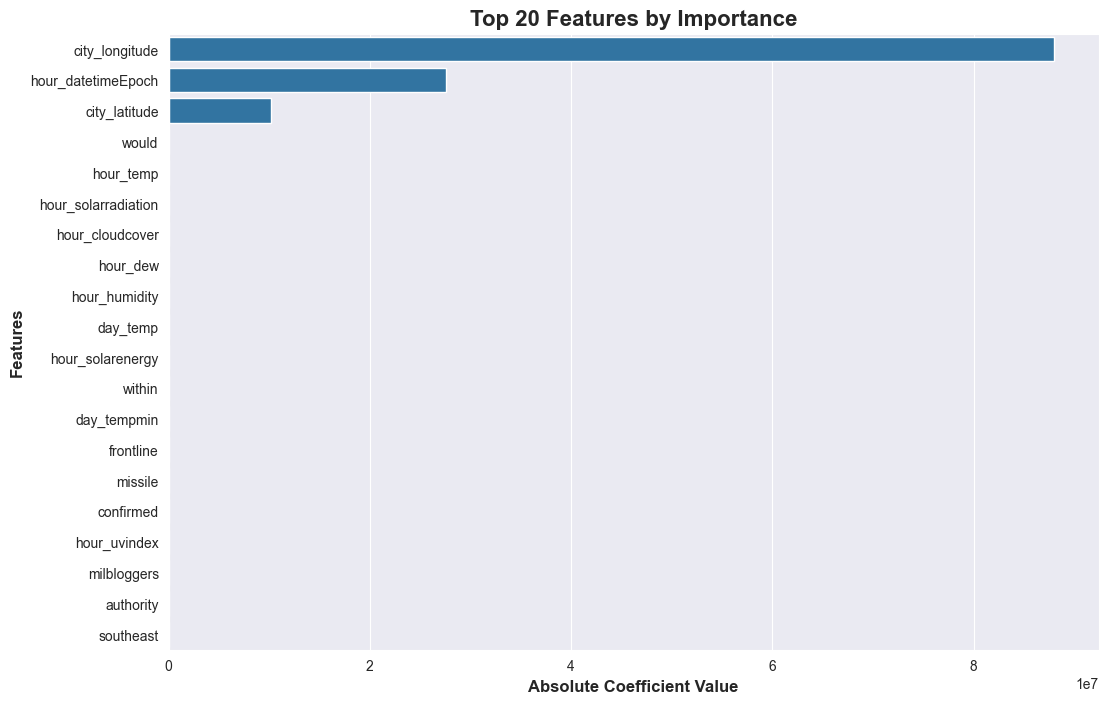

In [18]:
plt.figure(figsize=(12, 8))
sns.barplot(x="Importance", y="Feature", data=top_20)
plt.title("Top 20 Features by Importance", fontsize=16, fontweight="bold")
plt.xlabel("Absolute Coefficient Value", fontsize=12, fontweight="bold")
plt.ylabel("Features", fontsize=12, fontweight="bold");

We can observe a strong dependence on features like `city_longitude`, `hour_datetimeEpoch`, and `city_latitude`, which dominate the model. These features have significantly higher coefficients compared to the others. To better understand the influence of other features, let's plot the feature importance again, excluding these three, and identify the remaining important features.

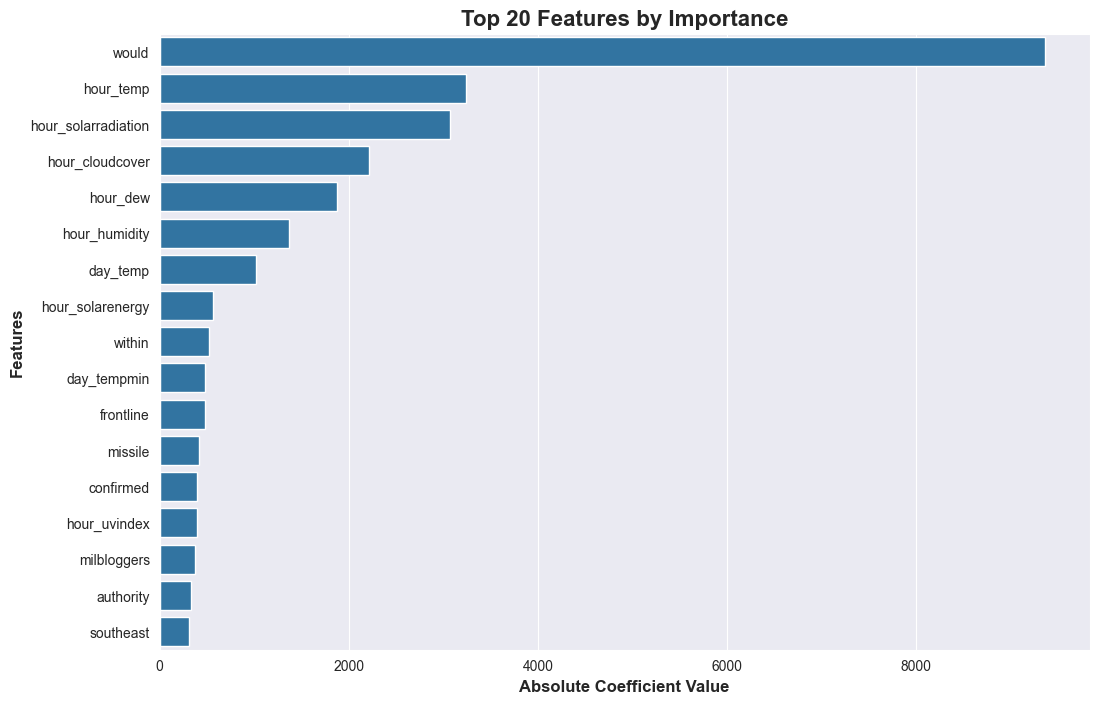

In [19]:
top_20 = top_20.iloc[3:]
plt.figure(figsize=(12, 8))
sns.barplot(x="Importance", y="Feature", data=top_20)
plt.title("Top 20 Features by Importance", fontsize=16, fontweight="bold")
plt.xlabel("Absolute Coefficient Value", fontsize=12, fontweight="bold")
plt.ylabel("Features", fontsize=12, fontweight="bold");

- The feature **`would`** stands out as the most important, with a significantly higher coefficient compared to the other features. This indicates it has a strong influence on the model’s predictions.
- **`hour_temp`**, **`hour_solarradiation`**, and **`hour_cloudcover`** are also highly influential features.

### Conclusion on the Regression Part

1. The overall result is quite good. An MAE of 1.8 hours for predicting the next alarm is a strong outcome, but there is still room for improvement.
2. A significant dependence on features like `city_latitude` and `city_longitude` is observed. We should consider testing the model without these features to evaluate their true impact. The `hour_datetimeEpoch` column, however, remains valuable as it provides temporal information, making it easier to predict the correct time.
3. The weather data appears to be much more valuable in predicting the target than the **ISW reports**, indicating that weather-related features play a more substantial role.

Check the Model Without the Mentioned Columns

In [20]:
X_regression_test = X_regression.drop(["city_longitude", "city_latitude"], axis=1)
num_attribs = X_regression_test.select_dtypes(include="number").columns.tolist()
cat_attribs = ["hour_conditions", "region", "hour_preciptype"]

num_regression_pipeline = Pipeline([
    ("std_scaler", StandardScaler()),
])

full_regression_pipeline = ColumnTransformer([
    ("num", num_regression_pipeline, num_attribs),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_attribs)
])
regression_pipeline = Pipeline([
    ("preprocessor", full_regression_pipeline),
    ("model", LinearRegression())
])

In [21]:
tscv = TimeSeriesSplit(n_splits=5)
rmse_scores = []
mae_scores = []
r2_scores = []
for train_index, test_index in tscv.split(X_regression_test):
    X_train_test, X_test_test = X_regression_test.iloc[train_index], X_regression_test.iloc[test_index]
    y_train, y_test = y_regression.iloc[train_index], y_regression.iloc[test_index]

    regression_pipeline.fit(X_train_test, y_train)
    y_pred = regression_pipeline.predict(X_test_test)

    rmse_scores.append(root_mean_squared_error(y_test, y_pred) / 3600)
    mae_scores.append(mean_absolute_error(y_test, y_pred) / 3600)
    r2_scores.append(r2_score(y_test, y_pred))
print(f"RMSE scores: {rmse_scores}")
print(f"Mean RMSE: {np.mean(rmse_scores):.4f} hours")
print(f"\nMAE scores: {mae_scores}")
print(f"Mean MAE: {np.mean(mae_scores):.4f} hours")

RMSE scores: [3.2136969564302547, 1.966689577226994, 1.983196086078611, 3.2315260013332443, 2.775012777213613]
Mean RMSE: 2.6340 hours

MAE scores: [2.3805569382436427, 1.4767773556882438, 1.4663877813559871, 1.7943548786700707, 1.9449388075046001]
Mean MAE: 1.8126 hours


We can see that the results have slightly improved, but the difference is less than 3 seconds. This indicates that the model’s performance doesn’t heavily depend on the `city_latitude` and `city_longitude` columns.

## Logistic Regression

In [22]:
tscv = TimeSeriesSplit(n_splits=5)
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []
confusion_matrices = []
pr_curves = []
roc_curves = []

for train_index, test_index in tscv.split(X_classification):
    X_train, X_test = X_classification.iloc[train_index], X_classification.iloc[test_index]
    y_train, y_test = y_classification.iloc[train_index], y_classification.iloc[test_index]

    classification_pipeline.fit(X_train, y_train)
    y_pred = classification_pipeline.predict(X_test)

    y_pred_proba = classification_pipeline.predict_proba(X_test)[:, 1]

    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    roc_auc_scores.append(roc_auc_score(y_test, y_pred_proba))
    confusion_matrices.append(confusion_matrix(y_test, y_pred))
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
    pr_curves.append((precision, recall, thresholds))
    fpr, tpr, threshold = roc_curve(y_test, y_pred_proba)
    roc_curves.append((fpr, tpr, threshold))

## Evaluating Regression model

### 1. Accuracy

`Accuracy` is the most common and straightforward metric used in **classification** tasks. It measures the **percentage of correct** predictions out of the **total number** of predictions.

However, `accuracy` is not always a reliable metric. We'll explore why this is the case later in the evaluation.

In [23]:
print(f"Accuracy scores: {accuracy_scores}")
print(f"Mean accuracy: {np.mean(accuracy_scores):.4f}")

Accuracy scores: [0.795848078269591, 0.7879378536419204, 0.7735556270461555, 0.7438828227012092, 0.7179001949170183]
Mean accuracy: 0.7638


In our case, the mean accuracy is 0.76, which seems like a strong result for an initial model training attempt and clearly outperforms a model that would make random guesses.
But let’s test a model that always predicts 0 and compare the results. This will help us understand whether the accuracy score truly reflects meaningful performance.

Creating a Simple Model That Always Predicts **Zero**

In [24]:
from sklearn.base import BaseEstimator, ClassifierMixin


class AlwaysZeroClassifier(BaseEstimator, ClassifierMixin):
    def fit(self, X, y=None):
        return self

    def predict(self, X):
        return np.zeros(X.shape[0], dtype=int)


accuracy_scores_zero = []
zero_classifier = AlwaysZeroClassifier()
for train_index, test_index in tscv.split(X_classification):
    X_train, X_test = X_classification.iloc[train_index], X_classification.iloc[test_index]
    y_train, y_test = y_classification.iloc[train_index], y_classification.iloc[test_index]

    zero_classifier.fit(X_train, y_train)
    y_pred = zero_classifier.predict(X_test)

    accuracy_scores_zero.append(accuracy_score(y_test, y_pred))

print(f"Accuracy scores: {accuracy_scores_zero}")
print(f"Mean accuracy: {np.mean(accuracy_scores_zero):.4f}")

Accuracy scores: [0.7970213651760877, 0.7638665480763772, 0.7299831576556971, 0.6418068618360048, 0.6335654675169843]
Mean accuracy: 0.7132


The results from our `AlwaysZeroClassifier` are surprisingly close to those of the trained model when measured using accuracy.

This clearly demonstrates why **accuracy is not a reliable metric** for classification tasks—especially in the case of **imbalanced datasets**.

A high accuracy can be achieved simply by predicting the majority class, but this does not mean the model is actually learning useful patterns.

To gain a more complete understanding of our model's performance, we will now explore other metrics.

## 2. Confusion Matrix

A **confusion matrix** is a useful tool for visualizing the performance of a classification model. It shows the number of correct and incorrect predictions made by the model, broken down by each class. This allows us to see **not only how many predictions were right**, but also **where the model went wrong**.

For binary classification, the confusion matrix consists of **four components**:

- **True Positives (TP)**: The model predicted class **1**, and the actual class was also **1**.
- **True Negatives (TN)**: The model predicted class **0**, and the actual class was also **0**.
- **False Positives (FP)**: The model predicted class **1**, but the actual class was **0**.
- **False Negatives (FN)**: The model predicted class **0**, but the actual class was **1**.

This breakdown helps in understanding **which types of errors the model is making** and forms the basis for other important metrics like **precision**, **recall**, and **F1-score**.

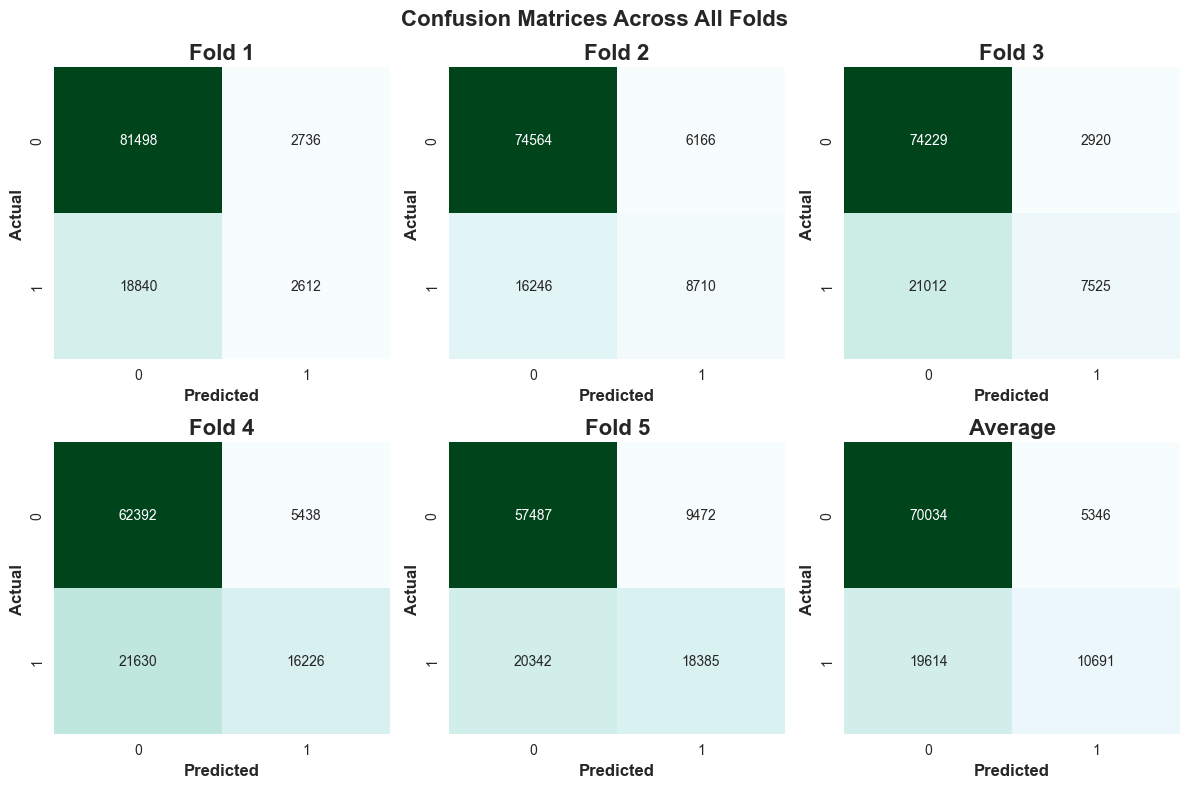

In [25]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()
classes = ["0", "1"]
for i, cm in enumerate(confusion_matrices):
    sns.heatmap(cm, annot=True, fmt="d", cmap="BuGn", cbar=False,
                xticklabels=classes, yticklabels=classes, ax=axes[i])
    axes[i].set_title(f"Fold {i + 1}", fontsize=16, fontweight="bold")
    axes[i].set_xlabel("Predicted", fontsize=12, fontweight="bold")
    axes[i].set_ylabel("Actual", fontsize=12, fontweight="bold")

avg_cm = np.mean(confusion_matrices, axis=0).astype(int)
sns.heatmap(avg_cm, annot=True, fmt="d", cmap="BuGn", cbar=False,
            xticklabels=classes, yticklabels=classes, ax=axes[-1])
axes[-1].set_title("Average", fontsize=16, fontweight="bold")
axes[-1].set_xlabel("Predicted", fontsize=12, fontweight="bold")
axes[-1].set_ylabel("Actual", fontsize=12, fontweight="bold")
plt.suptitle("Confusion Matrices Across All Folds", fontsize=16, fontweight="bold")
plt.tight_layout();

From the confusion matrices across all five folds, we can clearly observe that the **True Negatives (TN)** consistently have the highest values. This is expected given the likely class imbalance in the dataset, where negative cases dominate.

However, a deeper issue is visible when we look at the **False Negatives (FN)** — instances where the actual class is `1`, but the model incorrectly predicts `0`. In every fold, the number of FNs is significantly higher than the number of **False Positives (FP)**. This indicates that the model struggles to identify positive cases.

This reinforces the need to consider metrics like **precision**, **recall**, and the **F1-score**. In particular Improving TP while reducing FN should be a key goal in future model tuning.

### 3. Precision

**Precision** is an important metric that evaluates the quality of positive predictions.

**Precision= TP/(TP+FP)**

A high precision means that when the model predicts class `1`, it's usually correct — which is especially important in contexts where **false positives are costly**.

In [26]:
print(f"Precision scores: {precision_scores}")
print(f"Mean precision: {np.mean(precision_scores):.4f}")

Precision scores: [0.48840688107703817, 0.5855068566819037, 0.7204404021062709, 0.7489844903988183, 0.6599777434756076]
Mean precision: 0.6407


We can see that our model performs quite well in the later folds, with notably higher precision scores. However, the first and second folds show considerably lower precision, and we can see it from confusion matrix.

### 4. Recall

**Recall** is a crucial metric that measures the model's ability to correctly identify all actual positive cases.

**Recall = TP / (TP + FN)**

It tells us what proportion of actual positives the model successfully detected. A high recall means the model is good at **catching true positives**, which is particularly important in situations where **false negative** has serious consequences .

In [27]:
print(f"Recall scores: {recall_scores}")
print(f"Mean recall: {np.mean(recall_scores):.4f}")

Recall scores: [0.12176020883833676, 0.3490142651065876, 0.26369274976346496, 0.4286242603550296, 0.4747333901412451]
Mean recall: 0.3276


The recall scores for our model are consistently low across all folds, indicating that it has difficulty correctly identifying actual positive cases.

This is a significant concern in our task, where detecting positive instances is crucial. Enhancing recall should be considered a **key objective** in future model improvements and tuning efforts.

## Precision vs Recall

While precision and recall each highlight different aspects of model performance, relying on just one can be misleading — especially in imbalanced datasets. To strike a balance between the two, we use the **F1 Score**.

### 4. F1 Score

The **F1 Score** is the harmonic mean of **precision** and **recall**, providing a single metric that balances both false positives and false negatives. It is particularly useful when you need to find a trade-off between **precision** and **recall**.

The formula for the F1 Score is:

**F1-Score = 2× ( ( Precision * Recall ) / ( Precision + Recall ) )**

F1 score will only be high if **both precision and recall are reasonably high**.

In [28]:
print(f"F1 scores: {f1_scores}")
print(f"Mean F1: {np.mean(f1_scores):.4f}")

F1 scores: [0.19492537313432837, 0.43733681462140994, 0.3860756246472731, 0.545228494623656, 0.552234771116184]
Mean F1: 0.4232


Overall, these results confirm that while precision is somewhat acceptable in later folds, the recall remains a limiting factor, pulling down the F1 score.

### 5. Precision Recall Curve

The Precision-Recall curve is a useful tool for selecting a **decision threshold** that aligns with the specific goals of the task.

For example, if our objective is to achieve a **recall of 0.9**, regardless of the resulting precision, we can use the curve to identify the threshold that meets this requirement. Similarly, if we prioritize achieving a certain level of **precision**, the curve helps us find the corresponding threshold — even if it comes at the cost of lower recall.

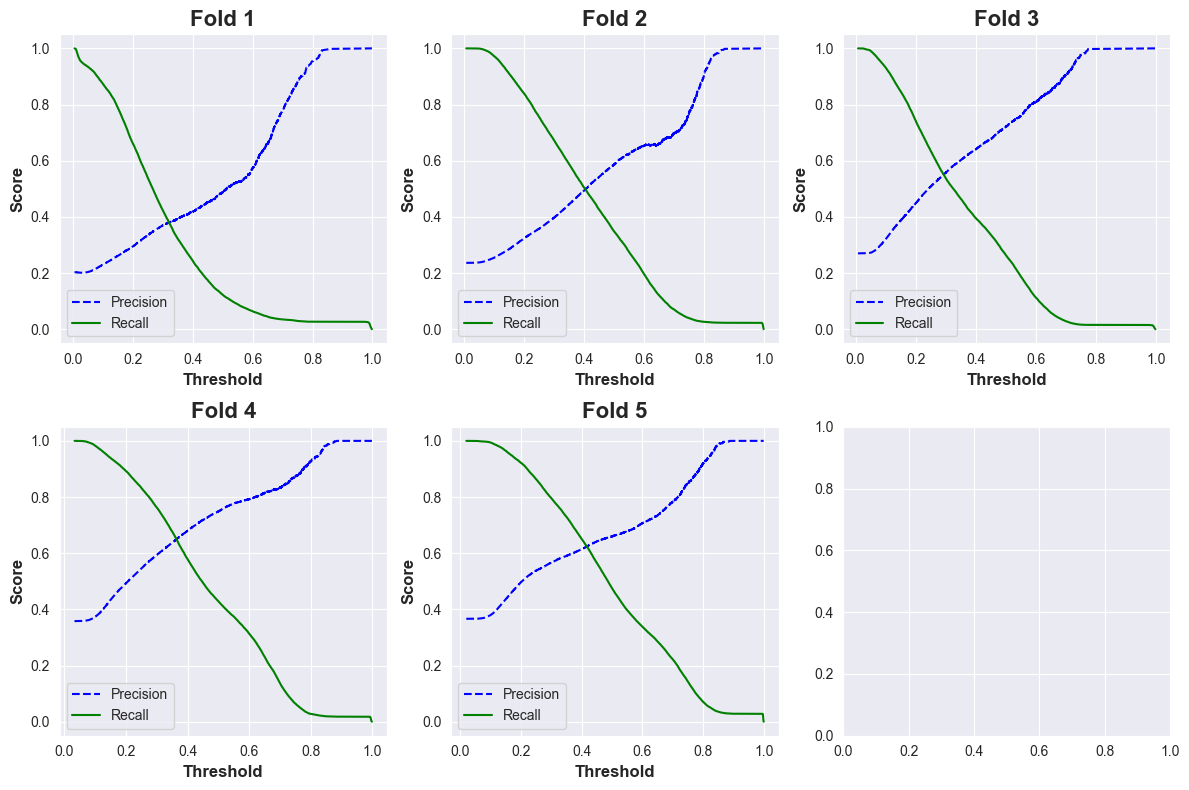

In [29]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()
for i, (precisions, recalls, thresholds) in enumerate(pr_curves):
    ax = axes[i]
    ax.plot(thresholds, precisions[:-1], "b--", label="Precision")
    ax.plot(thresholds, recalls[:-1], "g-", label="Recall")
    ax.set_title(f"Fold {i + 1}", fontsize=16, fontweight="bold")
    ax.set_xlabel("Threshold", fontsize=12, fontweight="bold")
    ax.set_ylabel("Score", fontsize=12, fontweight="bold")
    ax.legend(loc="best")
plt.tight_layout();

We can clearly observe the trade-off between **precision and recall** on the curve. It becomes evident that it's impossible to achieve both **high recall and high precision** simultaneously. As one increases, the other decreases.

Let’s aim to achieve a **recall of 0.6**, and use the **last fold** to determine the appropriate threshold for this goal — since it represents the most recent data.

Once we identify the threshold that gives us this recall level, we can evaluate the resulting precision and overall performance to see how well the model meets our updated objective.

In [30]:
threshold_60_recall = thresholds[np.argmin(recall >= 0.60)]
y_test_rec_60 = (y_pred_proba > threshold_60_recall)
print(f"Precision score:{precision_score(y_test, y_test_rec_60)}")
print(f"Recall score:{recall_score(y_test, y_test_rec_60)}")
print(f"Accuracy :{accuracy_score(y_test, y_test_rec_60)}")

Precision score:0.632031335001632
Recall score:0.5999948356443825
Accuracy :0.7254224779062506


We can see that while we achieved a recall of 60%, it came at the cost of a slightly lower precision. Additionally, the accuracy on the last fold improved by about 1%, indicating a better overall balance at this threshold.

Overall, this plot helps us identify the optimal threshold for our model, allowing us to fine-tune performance based on the specific priorities of the task—whether that’s maximizing recall, precision, or overall accuracy.

### 6. ROC Curve and AUC (Area Under the ROC Curve)

The **ROC (Receiver Operating Characteristic) curve** is a graphical representation that illustrates the diagnostic ability of a binary classification model. It plots the **True Positive Rate (TPR or Recall)** against the **False Positive Rate (FPR)** at various threshold settings.

The **AUC (Area Under the ROC Curve)** quantifies the overall ability of the model to discriminate between the positive and negative classes. It summarizes the entire ROC curve into a single value ranging from 0 to 1.

- An **AUC of 0.5** indicates no discriminative power (equivalent to random guessing).
- An **AUC of 1.0** indicates perfect classification.

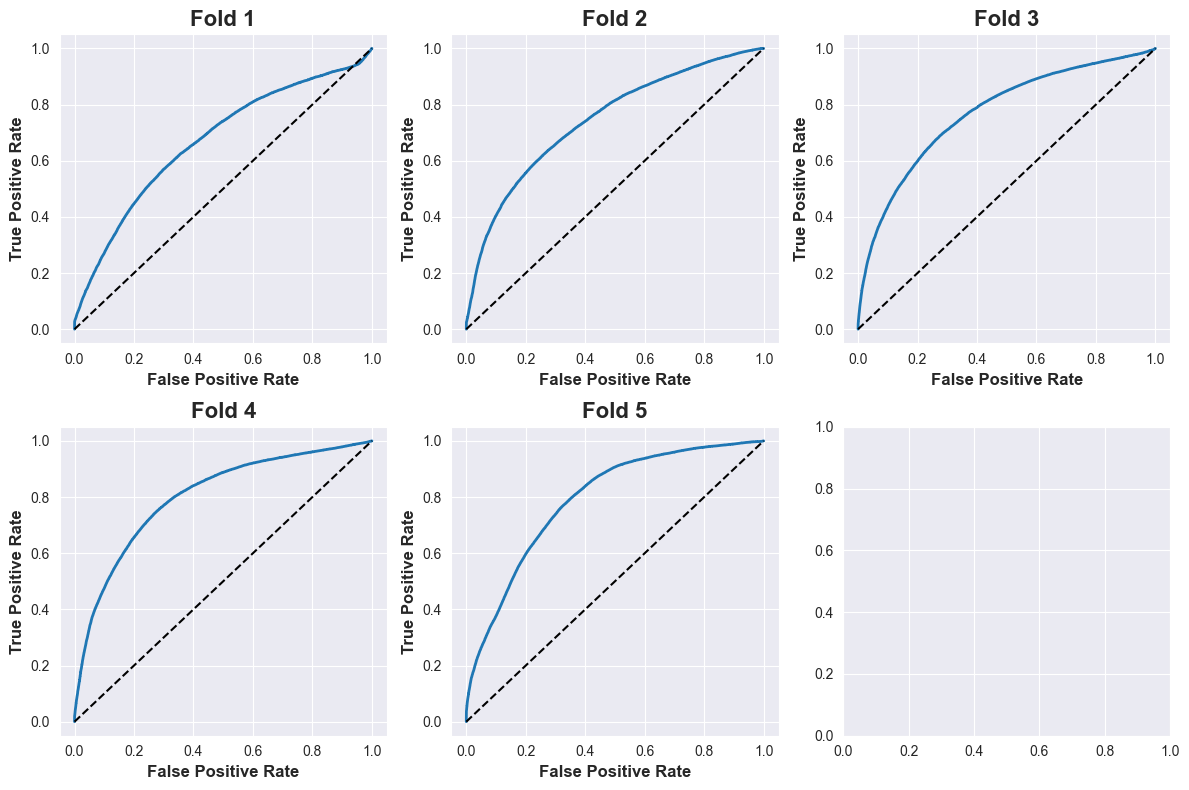

In [31]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()
for i, (fpr, tpr, thresholds) in enumerate(roc_curves):
    ax = axes[i]
    ax.plot(fpr, tpr, linewidth=2)
    ax.plot([0, 1], [0, 1], "k--")
    ax.set_title(f"Fold {i + 1}", fontsize=16, fontweight="bold")
    ax.set_xlabel("False Positive Rate", fontsize=12, fontweight="bold")
    ax.set_ylabel("True Positive Rate", fontsize=12, fontweight="bold")
plt.tight_layout();

In [32]:
print(f"ROC AUC scores: {roc_auc_scores}")
print(f"Mean ROC AUC: {np.mean(roc_auc_scores):.4f}")

ROC AUC scores: [np.float64(0.6697427455967151), np.float64(0.7438357809757561), np.float64(0.7698602757683233), np.float64(0.8014714870688231), np.float64(0.7900827105692472)]
Mean ROC AUC: 0.7550


The ROC AUC scores indicates that our model has a decent ability to distinguish between the positive and negative classes.

### Conclusion

In this classification task, we explored various performance metrics to evaluate how well our model distinguishes between the positive and negative classes.

While the **initial accuracy** of 76% seemed promising, further analysis using **confusion matrices**, **precision**, **recall**, and **F1-score** revealed that the model struggles to detect positive cases reliably — especially in earlier folds. The **low recall scores** highlight a tendency to miss a large number of actual positives, which is critical for our use case.

Through the use of **precision-recall curves**, we demonstrated how different thresholds can be used to balance precision and recall depending on the specific goals of the application. Similarly, the **ROC AUC scores** suggest the model has a reasonable ability to differentiate between the two classes, though there's still room for improvement.

### Identifying the Best Model

**Logistic Regression** offer a few hyperparameters that can influence its performance.

- **`penalty`**: Specifies the type of regularization to apply.
  - `"l2"` adds ridge regularization to prevent overfitting.
  - `"none"` disables regularization.

- **`fit_intercept`**: Specifies whether to calculate the intercept for the model.
  - `True` adds an intercept term.
  - `False` forces the decision boundary to pass through the origin.

    > As we observed in the regression task, changing the `fit_intercept` parameter did not improve performance

In [33]:
param_grid = {
    "preprocessor__num__pca__n_components": [0.5, 1, 10, 50],
    "model__penalty": ["l2", None]
}

Even though `Logistic Regression` has more hyperparameters compared to `Linear Regression`, we will still use `GridSearchCV` to explore all possible combinations.

While we’ve noted that accuracy is not the most reliable metric for our model, we will use it here as the scoring criterion, as it provides a general overview of overall model performance across all classes.

In [34]:
grid_search = GridSearchCV(
    classification_pipeline,
    param_grid,
    cv=tscv,
    scoring="accuracy",
    n_jobs=-1,
)

grid_search.fit(X_classification, y_classification)
best_classification_model = grid_search.best_estimator_
best_classification_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=50))]),
                                                  ['city_latitude',
                                                   'city_longitude',
                                                   'day_tempmax', 'day_tempmin',
                                                   'day_temp',
                                                   'day_precipcover',
                                                   'day_moonphase',
                                                   'hour_datetimeEpoch',
                                                   'hour_temp', 'hour_humidity',
                                                   'hour_dew', 'hour_precip',
                                                   'hour_precipprob',
                                                   '...
                                                   'hour_windgust',
                                                   'hour_windspeed',
                                                   'hour_winddir',
                                                   'hour_pressure',
                                                   'hour_visibility',
                                                   'hour_cloudcover',
                                                   'hour_solarradiation',
                                                   'hour_solarenergy',
                                                   'hour_uvindex', 'advanced',
                                                   'air', 'army', 'artillery',
                                                   'authority', 'avdiivka', ...]),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['hour_conditions', 'region',
                                                   'hour_preciptype'])])),
                ('model', LogisticRegression(max_iter=1000))])

In [35]:
grid_search.best_params_

{'model__penalty': 'l2', 'preprocessor__num__pca__n_components': 50}

In [36]:
print(f"Best accuracy: {grid_search.best_score_:.4f}")

Best accuracy: 0.7622


We can see that the results are worse than what we achieved with our original model. However, it’s important to note that the **`n_components`** parameter in PCA was set to **`None`** by default, meaning all features were retained without dimensionality reduction. As a result, the model worked with all available features, which may have led to overfitting or reduced performance when compared to a more optimized approach.

In [37]:
cvres = grid_search.cv_results_
for accuracy, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(accuracy, params)

0.7608898056507012 {'model__penalty': 'l2', 'preprocessor__num__pca__n_components': 0.5}
0.7536248888216036 {'model__penalty': 'l2', 'preprocessor__num__pca__n_components': 1}
0.7613326268379919 {'model__penalty': 'l2', 'preprocessor__num__pca__n_components': 10}
0.76218420604432 {'model__penalty': 'l2', 'preprocessor__num__pca__n_components': 50}
0.7608065401283046 {'model__penalty': None, 'preprocessor__num__pca__n_components': 0.5}
0.754052570823004 {'model__penalty': None, 'preprocessor__num__pca__n_components': 1}
0.7613193800503378 {'model__penalty': None, 'preprocessor__num__pca__n_components': 10}
0.7621747440531386 {'model__penalty': None, 'preprocessor__num__pca__n_components': 50}


## Top Features for the Classification task

In [38]:
feature_importance = list(zip(X_classification.columns, abs(grid_search.best_estimator_["model"].coef_[0])))
importance_df = pd.DataFrame(feature_importance, columns=["Feature", "Importance"])
importance_df = importance_df.sort_values("Importance", ascending=False)
top_20 = importance_df.head(20)

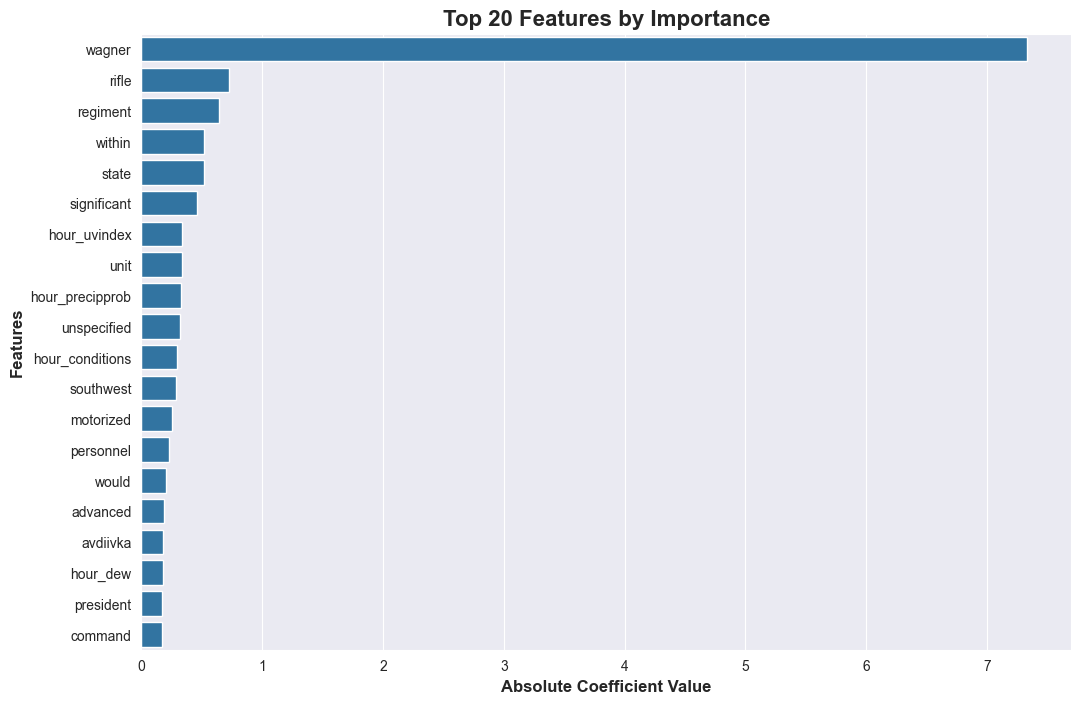

In [39]:
plt.figure(figsize=(12, 8))
sns.barplot(x="Importance", y="Feature", data=top_20)
plt.title("Top 20 Features by Importance", fontsize=16, fontweight="bold")
plt.xlabel("Absolute Coefficient Value", fontsize=12, fontweight="bold")
plt.ylabel("Features", fontsize=12, fontweight="bold");

- The feature **`wagner`** stands out as the most important, with a significantly higher coefficient compared to the other features. This suggests it has a major influence on the model’s predictions.
- **`unit`**, **`southeast`**, and **`significant`** also appear to be highly influential in the model.

### Conclusion on the Classification Part:

1. The overall model performs well, with key features playing a significant role in the decision-making process. However, there’s still room for optimization in terms of feature selection and tuning.
2. Certain features like **`state`**, and **`within`** seem to have a large impact on predictions.